In [1]:
import numpy as np
import matplotlib.pyplot as plt

import copy
import torch 
import torch.nn as nn
import torch.nn.functional as F
from importlib import reload

In [2]:
from Utils import test_env
from RelationalModule import ControlNetworks as cnet

In [3]:
reload(test_env)
reload(cnet)

<module 'RelationalModule.ControlNetworks' from '/home/nicola/Nicola_unipd/MasterThesis/RelationalDeepRL/RelationalModule/ControlNetworks.py'>

In [4]:
def random_start(X=10, Y=10):
    s1, s2 = np.random.choice(X*Y, 2, replace=False)
    initial = [s1//X, s1%X]
    goal = [s2//X, s2%X]
    return initial, goal

In [5]:
# Variable parameters
X = 10
Y = 10
initial, goal = random_start(X, Y)

# All game parameters
game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=100, greyscale_state=True)

In [6]:
env = test_env.Sandbox(**game_params)

In [7]:
state = env.reset()

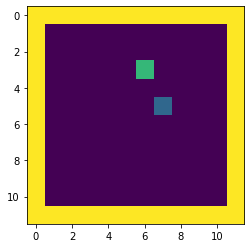

In [8]:
plt.imshow(state.reshape(12,12))
plt.show()

## Using One Hot Encoding for the state representation

In [9]:
colors = [1,2,3]
ohe_state = np.full((3,)+state.shape[1:], 0).astype(float)
print(ohe_state.shape)
for i, c in enumerate(colors):
    mask = (state[0,:,:] == c)
    ohe_state[i][mask] = 1.

(3, 12, 12)


In [10]:
n_features = 32
map_size = 10
hidden_dim = 128
n_residuals = 4

OHE_conv = cnet.Convolution(k_in=3, k_out=24)
pos_enc = cnet.PositionalEncoding(n_kernels=24, n_features=n_features)

pixel_res_layer = cnet.ResidualLayer(map_size**2, hidden_dim)
pixel_res_layers = cnet.clones(pixel_res_layer, n_residuals)
pixel_res_block = nn.Sequential(*pixel_res_layers)

maxpool = cnet.FeaturewiseMaxPool(pixel_axis=2)

feature_res_layer = cnet.ResidualLayer(n_features, n_features)
feature_res_layers = cnet.clones(feature_res_layer, n_residuals)
feature_res_block = nn.Sequential(*feature_res_layers)

In [12]:
x = torch.tensor(ohe_state).float()
print("Input shape: ", x.shape)
x = OHE_conv(x)
print("conv_state.shape: ", x.shape)
x = pos_enc(x)
print("After positional enc + projection: ", x.shape)
x = x.permute(1,2,0)
print("x.shape: ", x.shape)
x = pixel_res_block(x) # Interaction between pixels feature-wise
print("x.shape: ", x.shape)
x = maxpool(x) # Feature-wise maxpooling
print("x.shape: ", x.shape)
x = feature_res_block(x) # Interaction between features -> final representation
print("x.shape: ", x.shape)

Input shape:  torch.Size([3, 12, 12])
conv_state.shape:  torch.Size([1, 24, 10, 10])
After positional enc + projection:  torch.Size([100, 1, 32])
x.shape:  torch.Size([1, 32, 100])
x.shape:  torch.Size([1, 32, 100])
x.shape:  torch.Size([1, 32])
x.shape:  torch.Size([1, 32])


In [16]:
reload(cnet)

<module 'RelationalModule.ControlNetworks' from '/home/nicola/Nicola_unipd/MasterThesis/RelationalDeepRL/RelationalModule/ControlNetworks.py'>

In [17]:
ohenet = cnet.OheNet(map_size=10)

In [18]:
x = torch.tensor(ohe_state).float()
y = ohenet(x)
print(y.shape)

torch.Size([1, 32])


In [ ]:
vocab_size = 4
n_dim = 3
d_model = 16
n_heads = 2
linear_size = 12

embed = nn.Embedding(vocab_size, n_dim, padding_idx=0)
pos_enc = cnet.PositionalEncoding(n_dim, d_model)
relational = cnet.AttentionBlock(d_model, n_heads)
projection = nn.Linear(linear_size**2, 1)

In [ ]:
x = torch.LongTensor(state)
if len(x.shape) <= 3:
    x = x.unsqueeze(0)
x = embed(x)
x = x.permute(0,1,4,2,3)
x = x.reshape(x.shape[:1]+(-1,)+x.shape[3:])
x = pos_enc(x)
x = relational(x)
x = x.permute(1,2,0)
x = projection(x)
x = x.reshape(x.shape[0],-1)

In [ ]:
HPs = dict( vocab_size = 4,
            n_dim = 3,
            n_features = 16,
            n_heads = 2,
            linear_size = X+2)

control_net = cnet.ControlNet(**HPs)

In [ ]:
x = torch.LongTensor(state)
y = control_net(x)
y.shape

# Solving env with just coordinates
State = [x_agent, y_agent, x_goal, y_goal] <br>
All coordinates rescaled in [0,1] dividing for the linear size of the map

In [ ]:
def random_start(X=10, Y=10):
    s1, s2 = np.random.choice(X*Y, 2, replace=False)
    initial = [s1//X, s1%X]
    goal = [s2//X, s2%X]
    return initial, goal

In [ ]:
# Variable parameters
X = 10
Y = 10
initial, goal = random_start(X, Y)

# All game parameters
game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=100, 
                   greyscale_state=False, return_coord=True)

In [ ]:
env = test_env.Sandbox(**game_params)

In [ ]:
state = env.reset()

In [ ]:
print("Agent initial coordinates: ", initial)
print("Goal coordinates: ", goal)
print("Linear dimension: ", X)
print("Initial state: ", state)


In [ ]:
from RelationalModule import MLP_AC_networks as MLP_nets

In [ ]:
actor_HPs = dict(observation_space=5, action_space=4, hiddens=[32,16])
actor = MLP_nets.Actor(**actor_HPs)

In [ ]:
x = torch.tensor(state).unsqueeze(0).float()
print(x.shape)
log_probs = actor(x) 

In [ ]:
p = torch.exp(log_probs)
p.sum()